In [1]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "starter_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from starter_pack directory.")


ModuleNotFoundError: No module named 'starter_pack'

In [2]:
# 06_custom_rankings_by_metric.ipynb
# 🏆 Build Custom Rankings by Any Team Stat

# 🛠 Requirements:
# - pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
current_year = config.current_year
DATA_DIR = str(config.data_dir)



plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [3]:
# 📂 Load {current_year} season advanced stats
stats_path = str(config.get_advanced_stats_path(year=current_year))
stats = pd.read_csv(stats_path)

# Filter to FBS teams only
teams = stats[stats["conference"].notnull()].copy()

print(f"{len(teams)} FBS teams loaded")
teams.head()


136 FBS teams loaded


,season,team,conference,offense_passingPlays_explosiveness,offense_passingPlays_successRate,offense_passingPlays_totalPPA,offense_passingPlays_ppa,offense_passingPlays_rate,offense_rushingPlays_explosiveness,offense_rushingPlays_successRate,...,defense_lineYardsTotal,defense_lineYards,defense_stuffRate,defense_powerSuccess,defense_explosiveness,defense_successRate,defense_totalPPA,defense_ppa,defense_drives,defense_plays
0,2025,Air Force,Mountain West,2.068482,0.483660,87.090222,0.569217,0.222384,0.952013,0.482042,...,980,3.265667,0.143333,0.738095,1.388718,0.498333,249.809410,0.416349,103,600
1,2025,Akron,Mid-American,1.520334,0.387500,67.515966,0.168790,0.512164,0.764946,0.430137,...,1088,2.963215,0.215259,0.596154,1.332486,0.412256,127.031010,0.176923,139,718
2,2025,Alabama,SEC,1.639582,0.495979,171.552351,0.459926,0.546120,0.858739,0.396721,...,851,2.791475,0.180328,0.717391,1.263637,0.383051,41.427867,0.070217,107,590
3,2025,App State,Sun Belt,1.594993,0.384075,70.273831,0.164576,0.596369,0.787054,0.425000,...,931,2.763798,0.195846,0.720000,1.254033,0.436986,128.120832,0.175508,119,730
4,2025,Arizona,Big 12,1.520213,0.417614,72.691844,0.206511,0.523031,1.046193,0.433962,...,1004,2.902601,0.190751,0.688889,1.201469,0.374251,58.829852,0.088069,119,668


In [4]:
# 🔍 Show all available numeric columns for selection

numeric_cols = teams.select_dtypes(include=["float64", "int64"]).columns.tolist()
excluded = ['season', 'year', 'games', 'plays']  # remove less useful fields
metric_options = [col for col in numeric_cols if col not in excluded]

print("Available metrics:")
for col in metric_options:
    print(f" - {col}")

Available metrics:
 - offense_passingPlays_explosiveness
 - offense_passingPlays_successRate
 - offense_passingPlays_totalPPA
 - offense_passingPlays_ppa
 - offense_passingPlays_rate
 - offense_rushingPlays_explosiveness
 - offense_rushingPlays_successRate
 - offense_rushingPlays_totalPPA
 - offense_rushingPlays_ppa
 - offense_rushingPlays_rate
 - offense_passingDowns_explosiveness
 - offense_passingDowns_successRate
 - offense_passingDowns_ppa
 - offense_passingDowns_rate
 - offense_standardDowns_explosiveness
 - offense_standardDowns_successRate
 - offense_standardDowns_ppa
 - offense_standardDowns_rate
 - offense_havoc_db
 - offense_havoc_frontSeven
 - offense_havoc_total
 - offense_fieldPosition_averagePredictedPoints
 - offense_fieldPosition_averageStart
 - offense_pointsPerOpportunity
 - offense_totalOpportunies
 - offense_openFieldYardsTotal
 - offense_openFieldYards
 - offense_secondLevelYardsTotal
 - offense_secondLevelYards
 - offense_lineYardsTotal
 - offense_lineYards
 - of

In [5]:
# 🧠 Define your metrics and weights here
# Format: ("metric_name", weight, higher_is_better)

ranking_config = [
    ("offense_ppa", 0.3, True),
    ("offense_successRate", 0.15, True),
    ("offense_explosiveness", 0.05, True),
    ("defense_ppa", 0.3, False),
    ("defense_successRate", 0.15, False),
    ("defense_explosiveness", 0.05, False)
]

# Sanity check: weights should sum to 1.0
assert abs(sum(w for _, w, _ in ranking_config) - 1.0) < 1e-6

In [6]:
# 📊 Normalize each metric and apply weight

ranked = teams[["team", "conference"]].copy()

for metric, weight, higher_is_better in ranking_config:
    # Normalize using min-max scaling
    col = teams[metric]
    if higher_is_better:
        norm = (col - col.min()) / (col.max() - col.min())
    else:
        norm = (col.max() - col) / (col.max() - col.min())
    
    ranked[metric + "_norm"] = norm
    ranked[metric + "_contrib"] = norm * weight


In [7]:
# 🏁 Final score and ranking

contrib_cols = [col for col in ranked.columns if col.endswith("_contrib")]
ranked["composite_score"] = ranked[contrib_cols].sum(axis=1)
ranked["rank"] = ranked["composite_score"].rank(ascending=False, method="min")
ranked = ranked.sort_values("rank").reset_index(drop=True)

# Show top 15
cols_to_show = ["team", "conference", "composite_score", "rank"] + contrib_cols
ranked[cols_to_show].head(15)


,team,conference,composite_score,rank,offense_ppa_contrib,offense_successRate_contrib,offense_explosiveness_contrib,defense_ppa_contrib,defense_successRate_contrib,defense_explosiveness_contrib
0,Ohio State,Big Ten,0.861640,1.0,0.284502,0.150000,0.008625,0.259963,0.108550,0.050000
1,Oregon,Big Ten,0.853128,2.0,0.300000,0.116888,0.035659,0.251139,0.106761,0.042682
2,Indiana,Big Ten,0.798576,3.0,0.261599,0.132893,0.017011,0.239844,0.127882,0.019347
3,Texas Tech,Big 12,0.774098,4.0,0.215401,0.083981,0.029115,0.274508,0.135508,0.035587
4,Toledo,Mid-American,0.753380,5.0,0.180320,0.079584,0.020989,0.300000,0.130104,0.042382
5,Utah,Big 12,0.753206,6.0,0.256998,0.110568,0.019773,0.239982,0.108762,0.017123
6,Miami,ACC,0.721278,7.0,0.193919,0.101226,0.012638,0.260227,0.119278,0.033991
7,USC,Big Ten,0.717417,8.0,0.297859,0.124488,0.033359,0.173951,0.051321,0.036439
8,Washington,Big Ten,0.704988,9.0,0.254972,0.119540,0.023735,0.194333,0.081002,0.031405
9,James Madison,Sun Belt,0.703897,10.0,0.185174,0.083234,0.031161,0.240058,0.150000,0.014271


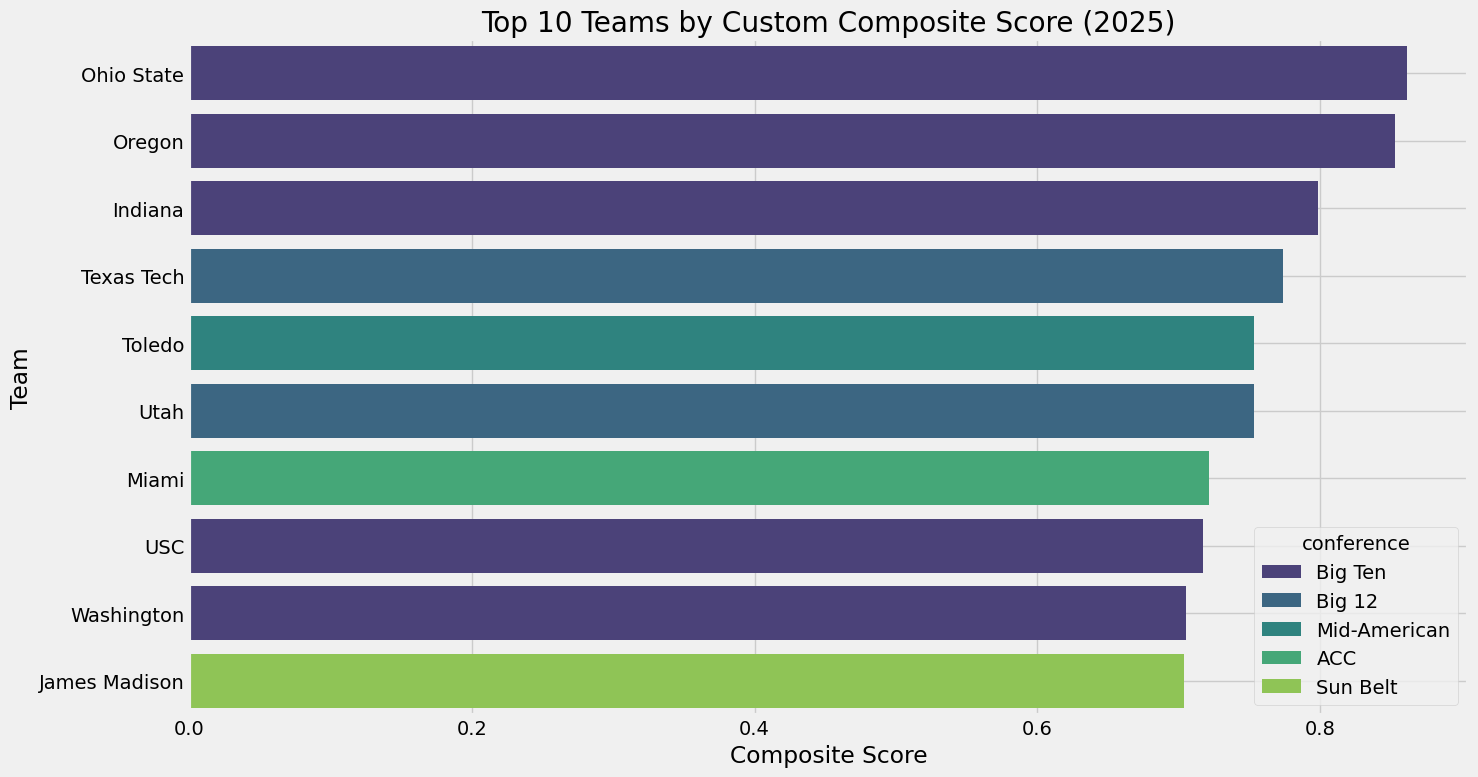

In [8]:
# 📊 Visualize top 10 teams by composite score

sns.barplot(
    data=ranked.head(10),
    x="composite_score",
    y="team",
    hue="conference",
    dodge=False,
    palette="viridis"
)
plt.title(f"Top 10 Teams by Custom Composite Score ({config.current_year})")
plt.xlabel("Composite Score")
plt.ylabel("Team")
plt.grid(True)
plt.tight_layout()
plt.show()


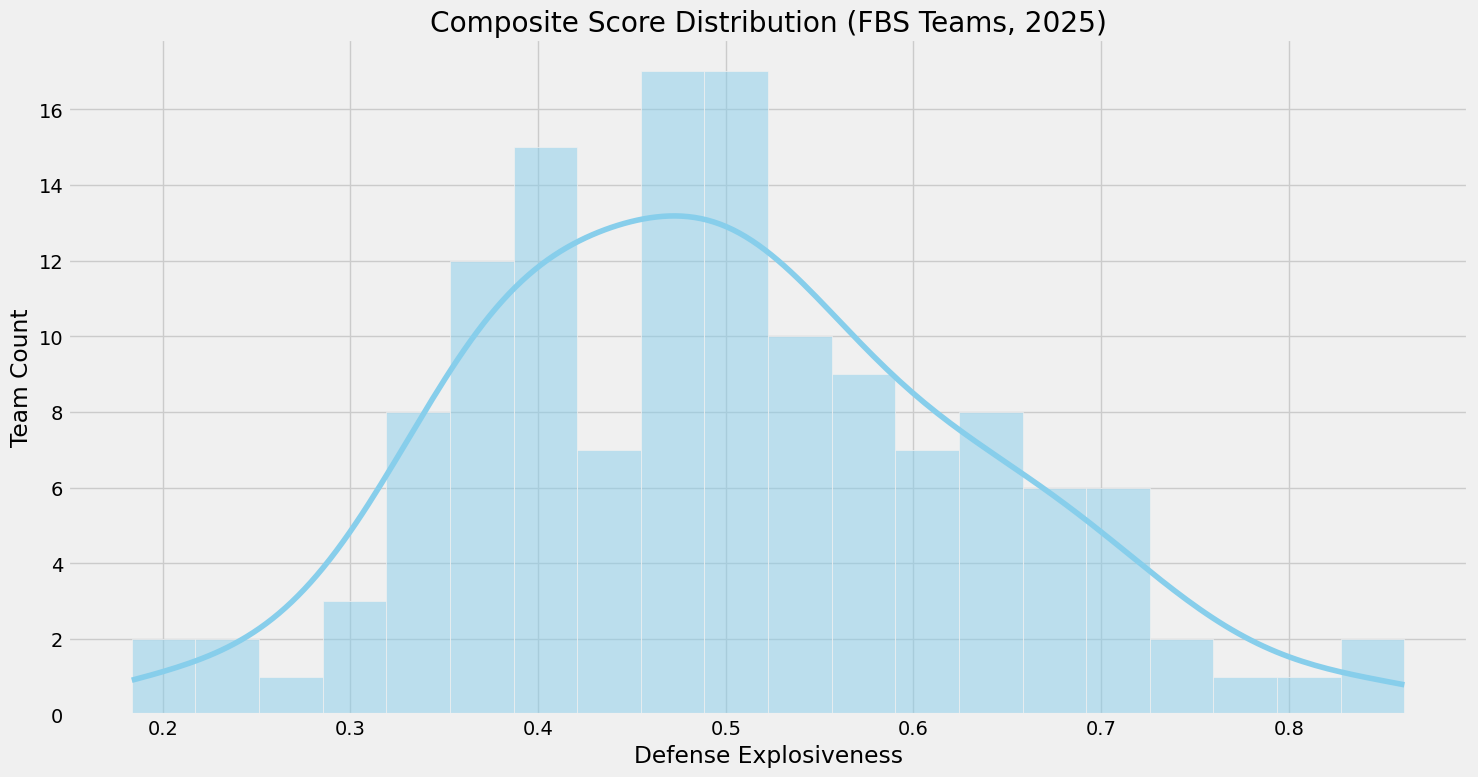

In [9]:
# 📈 Optional: Histogram of metric distribution

sns.histplot(
    data=ranked,
    x='composite_score',
    bins=20,
    kde=True,
    color="skyblue"
)
plt.title(f"Composite Score Distribution (FBS Teams, {config.current_year})")
plt.xlabel(metric.replace("_", " ").title())
plt.ylabel("Team Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# ✅ Summary

# You've just:
# - Defined a custom metric-weighted formula
# - Normalized and combined metrics
# - Ranked and visualized the top teams

# 🧪 Try This:
# - Swap in defensive stats or tempo
# - Create separate offense/defense rankings
# - Compare to your own intuition or betting spreads
